# SENG 550 Project
__Sentiment Analysis using TF-IDF and Random Forests to predict Amazon review ratings using review text and review summary__

Import all libraries

In [0]:
import re
import pandas as pd
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.mllib.tree import RandomForest
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import MulticlassMetrics

Read json data file and convert to dataframe

In [0]:
rdd = spark.read.json('/FileStore/tables/All_Beauty_5.json').rdd
print(rdd.take(1)[0])

Row(asin='B0000530HU', image=None, overall=5.0, reviewText='As advertised. Reasonably priced', reviewTime='09 1, 2016', reviewerID='A3CIUOJXQ5VDQ2', reviewerName='Shelly F', style=Row(Color:=None, Design:=None, Flavor:=' Classic Ice Blue', Scent Name:=None, Size:=' 7.0 oz', Style Name:=None), summary='Five Stars', unixReviewTime=1472688000, verified=True, vote=None)


Create function to parse a string and extract the data we need (overall, reviewText, summary)

In [0]:
def extractFeatures(row):
    """Extracts the features we want from the data.

    Args:
        line (pyspark.sql.types.Row): RDD row.

    Returns:
        tuple: A tuple with overall score, reviewText, and summary.
    """    
    overall = float(row.asDict()['overall'])
    
    reviewText = row.asDict()['reviewText']
    if reviewText:
        reviewText = re.sub(r'http\S+', '', reviewText)
        reviewText = re.sub(r'[^\w\s]', '', reviewText)
        reviewText = reviewText.lower()
        
    summary = row.asDict()['summary']
    if summary:
        summary = re.sub(r'http\S+', '', summary)
        summary = re.sub(r'[^\w\s]', '', summary)
        summary = summary.lower()
        
    processedText = ''
    if reviewText and summary:
        processedText = summary + ' ' + reviewText
        
    return (overall, processedText)

Apply `extractFeatures` to base RDD

In [0]:
extractedRDD = rdd.map(extractFeatures).collect()
print(extractedRDD)

[(5.0, 'five stars as advertised reasonably priced'), (5.0, 'good for the face like the oder and the feel when i put it on my face  i have tried other brands but the reviews from people i know they prefer the oder of this brand not hard on the face when dry  does not leave dry skin'), (1.0, 'smells awful i bought this to smell nice after i shave  when i put it on i smelled awful  i am 19 and i smelled like a grandmother with too much perfume'), (5.0, 'truth is there is nothing like an aqua velva man hey i am an aqua velva man and absolutely love this stuff been using it for over 50 years this is a true after shave lotion classic not quite sure how many women that have been attracted to me because of aqua velva  i do know for sure that its just to many to count ha  not sure how long this has been around but the williams company ran a paper advertisement taken from a 1949 magazine which features ralph bellamy of detective story and ezio pinza of south pacific for aqua velva after shave l

Text processing to remove punctuation and convert all characters to lowercase

In [0]:
df = spark.createDataFrame(extractedRDD, ['overall', 'review'])

tokenizer = Tokenizer(inputCol="review", outputCol="tokenizedReview")
tk = tokenizer.transform(df)

hashingTF = HashingTF(inputCol="tokenizedReview", outputCol="rawTokenizedReview", numFeatures=100)
tf = hashingTF.transform(tk)

tf.cache()
idf = IDF(inputCol="rawTokenizedReview", outputCol="features").fit(tf)
tfidf = idf.transform(tf)

df = tfidf.select("overall", "features").rdd

Perform Random Forest Classification

In [0]:
labelledPointRDD = df.map(lambda x: LabeledPoint(x['overall'], x['features'].toArray()))

training, validation, testing = labelledPointRDD.randomSplit([0.6, 0.2, 0.2])
training.cache()
validation.cache()
testing.cache()

model1 = RandomForest.trainClassifier(sc.parallelize(training.collect()), numClasses=6, categoricalFeaturesInfo={}, numTrees=10, maxDepth=5)
model2 = RandomForest.trainClassifier(sc.parallelize(training.collect()), numClasses=6, categoricalFeaturesInfo={}, numTrees=15, maxDepth=10)
model3 = RandomForest.trainClassifier(sc.parallelize(training.collect()), numClasses=6, categoricalFeaturesInfo={}, numTrees=20, maxDepth=15)
model4 = RandomForest.trainClassifier(sc.parallelize(training.collect()), numClasses=6, categoricalFeaturesInfo={}, numTrees=25, maxDepth=20)

Evaluate models

In [0]:
def evaluateMetrics(metrics, m_id):
    print()
    print("--------------------------------------------------------------")    
    print("Performance Metrics for Model " + str(m_id))
    print()
    print("Accuracy: %.2f" % (metrics.accuracy))
    for i in range(1, 6):
        print("Label " + str(i))
        print("Precision: %.2f" % (metrics.precision(i)))
        print("Recall: %.2f" % (metrics.recall(i)))
       # print("F-Score: %.2f%%" % (metrics.fMeasure(i,beta=1.0) * 100))
        print()

pred = model1.predict(validation.map(lambda x: x.features))
y_labels = validation.map(lambda x: x.label)
predAndLab = pred.zip(y_labels)
valMetrics = MulticlassMetrics(predAndLab)
evaluateMetrics(valMetrics, 1)

pred = model2.predict(validation.map(lambda x: x.features))
y_labels = validation.map(lambda x: x.label)
predAndLab = pred.zip(y_labels)
valMetrics = MulticlassMetrics(predAndLab)
evaluateMetrics(valMetrics, 2)

pred = model3.predict(validation.map(lambda x: x.features))
y_labels = validation.map(lambda x: x.label)
predAndLab = pred.zip(y_labels)
valMetrics = MulticlassMetrics(predAndLab)
evaluateMetrics(valMetrics, 3)

pred = model4.predict(validation.map(lambda x: x.features))
y_labels = validation.map(lambda x: x.label)
predAndLab = pred.zip(y_labels)
valMetrics = MulticlassMetrics(predAndLab)
evaluateMetrics(valMetrics, 4)


--------------------------------------------------------------
Performance Metrics for Model 1

Accuracy: 0.88
Label 1
Precision: 0.00
Recall: 0.00

Label 2
Precision: 1.00
Recall: 0.08

Label 3
Precision: 1.00
Recall: 0.10

Label 4
Precision: 1.00
Recall: 0.01

Label 5
Precision: 0.88
Recall: 1.00


--------------------------------------------------------------
Performance Metrics for Model 2

Accuracy: 0.93
Label 1
Precision: 1.00
Recall: 0.25

Label 2
Precision: 1.00
Recall: 0.67

Label 3
Precision: 0.78
Recall: 0.33

Label 4
Precision: 0.91
Recall: 0.46

Label 5
Precision: 0.93
Recall: 1.00


--------------------------------------------------------------
Performance Metrics for Model 3

Accuracy: 0.94
Label 1
Precision: 1.00
Recall: 0.25

Label 2
Precision: 0.80
Recall: 0.67

Label 3
Precision: 1.00
Recall: 0.14

Label 4
Precision: 0.98
Recall: 0.63

Label 5
Precision: 0.93
Recall: 1.00


--------------------------------------------------------------
Performance Metrics for Model 

Use optimal model for testing

In [0]:
test_labels = testing.map(lambda x: x.label)
testPred = model4.predict(testing.map(lambda x: x.features))
predAndLab = testPred.zip(test_labels)
testMetrics = MulticlassMetrics(predAndLab)
print("test data performance")
evaluateMetrics(testMetrics, 4)

test data performance

--------------------------------------------------------------
Performance Metrics for Model 4

Accuracy: 0.97
Label 1
Precision: 1.00
Recall: 0.96

Label 2
Precision: 1.00
Recall: 0.70

Label 3
Precision: 1.00
Recall: 0.61

Label 4
Precision: 0.98
Recall: 0.72

Label 5
Precision: 0.97
Recall: 1.00



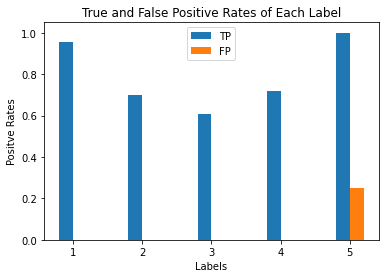

In [0]:
import matplotlib.pyplot as plt
import numpy as np
def positiveRates(metric, type):
    list = []
    for i in range(1,6):
        if type == 1:
            list.append(metric.truePositiveRate(float(i)))
        if type == 2:
            list.append(metric.falsePositiveRate(float(i)))            
    return list

truePos = positiveRates(testMetrics, 1)
falsePos = positiveRates(testMetrics, 2)

X = ['1', '2', '3', '4', '5']
X_axis = np.arange(5)

plt.bar(X_axis - 0.1, truePos, 0.2, label = 'TP')
plt.bar(X_axis + 0.1, falsePos, 0.2, label = 'FP')

plt.xticks(X_axis, X)
plt.xlabel("Labels")
plt.ylabel("Positve Rates")
plt.title("True and False Positive Rates of Each Label")
plt.legend()
plt.show()